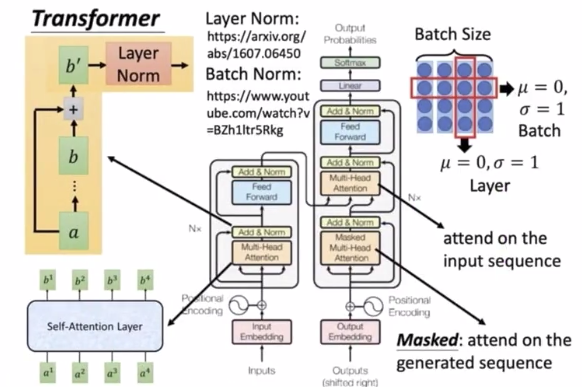

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os, sys, time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

from sklearn.model_selection import train_test_split

%matplotlib inline

print(tf.__version__)
print(sys.version_info)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 50
EPOCHS = 30

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

dropout_rate = 0.1

### Process data

In [0]:
def make_subword_token(dataset_name, target_vocab_size):
    """子词分词器（subwords tokenizer）。dataset_name -- 为tfds中提供的数据集名称"""
    examples, metadata = tfds.load(dataset_name,
                                   with_info=True,
                                   as_supervised=True)
    train_examples, val_examples = examples['train'], examples['validation']

    tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (en.numpy() for pt, en in train_examples),
        target_vocab_size=target_vocab_size)

    tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (pt.numpy() for pt, en in train_examples),
        target_vocab_size=target_vocab_size)

    return tokenizer_en, tokenizer_pt, metadata, train_examples, val_examples


def encode(lang1, lang2):
    """句子添加开始和结束标记"""
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size + 1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size + 1]

    return lang1, lang2


def tf_encode(pt, en):
    """图模式运行encode"""
    result_pt, result_en = tf.py_function(encode, [pt, en],
                                          [tf.int64, tf.int64])
    result_pt.set_shape([None])
    result_en.set_shape([None])

    return result_pt, result_en


def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length, tf.size(y) <= max_length)


def make_dataset(train_examples, val_examples):
    train_dataset = train_examples.map(tf_encode)
    train_dataset = train_dataset.filter(filter_max_length)
    train_dataset = train_dataset.cache()
    train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE,
        padded_shapes=([-1], [-1]))
    train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

    val_dataset = val_examples.map(tf_encode)
    val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE,
        padded_shapes=([-1], [-1]))
    
    return train_dataset, val_dataset

In [ ]:
tokenizer_en, tokenizer_pt, datainfo, train_examples, val_examples = make_subword_token('ted_hrlr_translate/pt_to_en',
    target_vocab_size=2**13)

train_dataset, val_dataset = make_dataset(train_examples, val_examples)

In [5]:
# test
print("#" * 10 + " Tokenize " + "#" * 10)
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print('The original string: {}'.format(original_string))

assert original_string == sample_string


for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

print("#" * 10 + " Batch " + "#" * 10)
pt_batch, en_batch = next(iter(val_dataset))
print("> Pt batch:", pt_batch)
print("> En batch:", en_batch)

########## Tokenize ##########
Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.
7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .
########## Batch ##########
> Pt batch: tf.Tensor(
[[8214  342 3032 ...    0    0    0]
 [8214   95  198 ...    0    0    0]
 [8214 4479 7990 ...    0    0    0]
 ...
 [8214   27 1300 ...    0    0    0]
 [8214  195    1 ...    0    0    0]
 [8214 1777  203 ... 3258    2 8215]], shape=(64, 49), dtype=int64)
> En batch: tf.Tensor(
[[8087   98   25 ...    0    0    0]
 [8087   12   20 ...    0    0    0]
 [8087   12 5453 ...    0    0    0]
 ...
 [8087   12 2509 ...    0    0    0]
 [8087 1252    1 ...    0    0    0]
 [8087   12  314 ...  425    2 8088]], shape=(64, 45), dtype=int64)


### Model layer compositions

#### Positional encoding
加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中产生距离的相对变化。

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
def get_angles(pos, i, d_model):
    """pos -- word id; i -- embedding dim id; d_model -- embedding dim"""
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(sentence_length, d_model):
    angle_rads = get_angles(
        np.arange(sentence_length)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :], d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def plot_position_embedding(sentence_length, d_model):
    pos_encoding = positional_encoding(sentence_length, d_model)
    print(pos_encoding.shape)

    plt.pcolormesh(pos_encoding[0], cmap='RdBu')
    plt.xlabel('Depth')
    plt.xlim((0, 512))
    plt.ylabel('Position')
    plt.colorbar()
    plt.show()

(1, 50, 512)


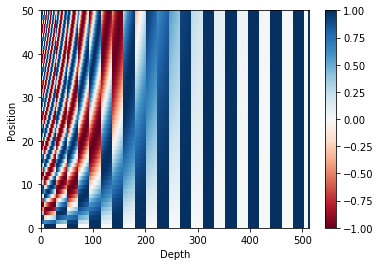

In [7]:
# test
plot_position_embedding(50, 512)

#### Masking

In [0]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # for two new: multi heads dim, and seq_len for attention
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def create_look_ahead_mask(size):
    """预测第三个词，将仅使用第一个和第二个词。每预测一次即有一个seq长度的mask。"""
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [9]:
# test
print("#" * 10 + " Padding_mask " + "#" * 10)
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

print("#" * 10 + " Look_ahead_mask " + "#" * 10)
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
print(temp)

########## Padding_mask ##########
tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
########## Look_ahead_mask ##########
tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


#### Scaled dot product attention

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

> 假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。用*`dk` 的平方根*缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax

In [0]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """计算注意力权重。
    计算要求seq_len_k = seq_len_v。
    mask 两种类型有不同的形状，要求必须能进行广播以便求和。
    
    q:  (..., seq_len_q, depth)
    k:  (..., seq_len_k, depth)
    v:  (..., seq_len_v, depth_v)
    mask: Float 张量，(..., seq_len_q, seq_len_k)，默认为None。

    return:
        output, attention_weights
    """
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # (..., seq_len_q, seq_len_k)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # pad part is -1e9
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

def print_out(q, k, v, mask=None):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, mask)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

In [11]:
# test
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)

mask = tf.constant([[[[0., 0., 0., 1.]]]])

print_out(temp_q, temp_k, temp_v, mask)

Attention weights are:
tf.Tensor([[[[0. 1. 0. 0.]]]], shape=(1, 1, 1, 4), dtype=float32)
Output is:
tf.Tensor([[[[10.  0.]]]], shape=(1, 1, 1, 2), dtype=float32)


#### Multi-head attention

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads  # 单个heads的 hidden units size

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        将统一转换后的heads：(batch_size, seq_len, d_model)
        拆分为Multi Heads：(batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
    
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)        
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
            (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

In [13]:
# test
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)

y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
x = tf.ones((1, 60))
mask = create_padding_mask(x)
out, attn = temp_mha(y, k=y, q=y, mask=mask)

print(out.shape, attn.shape)

(1, 60, 512) (1, 8, 60, 60)


#### Point wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, dff):
    """dff -- dim of feed forward network"""
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [15]:
# test
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Model

#### EncoderLayer，DecoderLayer

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
    """多头注意力 + Point wise feed forward networks"""
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """dff -- dim of feed forward network"""
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training=True, enc_mask=None):
        """enc_mask: padding中对补0位置的mask"""
        attn_output, _ = self.mha(x, x, x, enc_mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        # reset net way
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2
    
    
class DecoderLayer(tf.keras.layers.Layer):
    """多头注意力(有两种mask) + 多头注意力(只有一种mask) + Point wise feed forward networks"""
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """look_ahead_mask: decoder的单步预测将已知部分mask；
            padding_mask：encoder的k和v，与decoder的q进行注意力计算时padding mask 
        """
        # enc_output：(batch_size, input_seq_len, d_model)
        # attn1：(batch_size, target_seq_len, d_model)
        # look_ahead_mask保证了decoder单步解码的正确执行
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        
        # attn2: (batch_size, target_seq_len, d_model)
        # encoder与decoder的注意力相关计算
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

#### Encoder，Decoder

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                     num_layers,
                     d_model,
                     num_heads,
                     dff,
                     input_vocab_size,
                     maximum_position_encoding,
                     rate=0.1):
        """
            num_layers: EncoderLayer num; 
            d_model: total dim of multi heads; 
            dff: dim of feed forward network; 
            input_vocab_size ; 
            maximum_position_encoding: maximum defined sentence length for pos encoding
            rate: dropout rate
        """
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                                        for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # 保证x转化到 d ^ (1/2) 正态分布，且要比position encoding大
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)  # (batch_size, input_seq_len, d_model)
        
        return x

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                                       for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1  # decoder self
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2  # E-D weights

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

#### Transformer

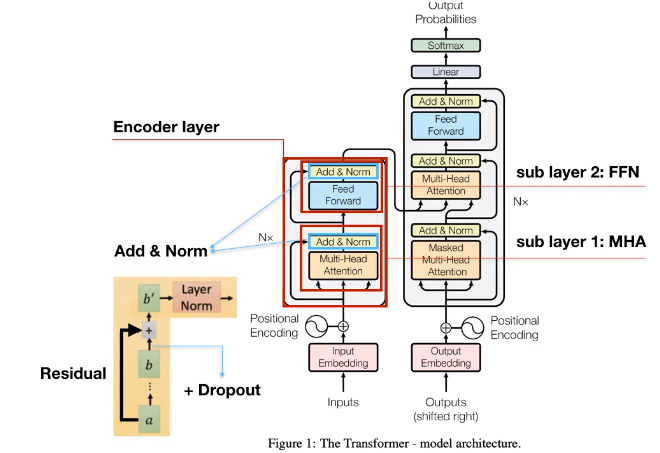

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, 
            num_layers, 
            d_model, 
            num_heads, 
            dff, 
            input_vocab_size, 
            target_vocab_size, 
            pe_input, 
            pe_target, 
            rate=0.1):
        """pe_input: maximum_position_encoding of input"""
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
            input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
            target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, 
            inp, 
            tar, 
            training, 
            enc_padding_mask, 
            look_ahead_mask, 
            dec_padding_mask):
        """
        inp -- encoder input;
        tar -- decoder input;
        """
         # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, enc_padding_mask) 
        
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, 
            enc_output, 
            training,
            look_ahead_mask, 
            dec_padding_mask)
        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)  

        return final_output, attention_weights

In [20]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000, 
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

### Optimizer

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

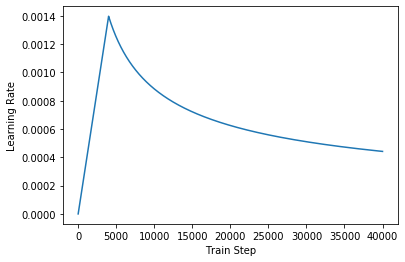

In [22]:
# test
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Loss

In [0]:
def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
        reduction='none')

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
  
    return tf.reduce_mean(loss_)

### Create mask

In [0]:
def create_masks(inp, tar):
    # 编码器使用
    enc_padding_mask = create_padding_mask(inp)
    
    # 在解码器的第二个注意力模块使用
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

### Params

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 50
EPOCHS = 30

num_layers = 4
d_model = 128
dff = 512
num_heads = 8

dropout_rate = 0.1

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2

### Train

In [0]:
## data
# tokenizer_en, tokenizer_pt, datainfo, train_examples, val_examples = make_subword_token('ted_hrlr_translate/pt_to_en',
#     target_vocab_size=2**13)

# train_dataset, val_dataset = make_dataset(train_examples, val_examples)

In [0]:
# optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
    epsilon=1e-9)

# metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# model
transformer = Transformer(num_layers, d_model, num_heads, dff,
  input_vocab_size, target_vocab_size, 
  pe_input=input_vocab_size, 
  pe_target=target_vocab_size,
  rate=dropout_rate)

In [0]:
# checkpoint
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [0]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    """inp -- encoder input; tar -- decoder teacher forcing data"""
    tar_inp = tar[:, :-1]  # decoder input
    tar_real = tar[:, 1:]  # decoder target

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                                     True, 
                                                     enc_padding_mask, 
                                                     combined_mask, 
                                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [0]:
def train(epochs, train_dataset, ckpt_manager):
    for epoch in range(epochs):
        start = time.time()

        train_loss.reset_states()
        train_accuracy.reset_states()

        # inp -> portuguese, tar -> english
        for (batch, (inp, tar)) in enumerate(train_dataset):
            train_step(inp, tar)

            if batch % 50 == 0:
                print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                            epoch + 1, batch, train_loss.result(), train_accuracy.result()))

        if (epoch + 1) % 5 == 0:
            ckpt_save_path = ckpt_manager.save()
            print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                                                             ckpt_save_path))

        print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                                                        train_loss.result(), 
                                                                                        train_accuracy.result()))

        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

In [34]:
train(EPOCHS, train_dataset, ckpt_manager)

Epoch 4 Batch 100 Loss 1.7879 Accuracy 0.1450
Epoch 4 Batch 150 Loss 1.7703 Accuracy 0.1456
Epoch 4 Batch 200 Loss 1.7625 Accuracy 0.1460
Epoch 4 Batch 250 Loss 1.7578 Accuracy 0.1464
Epoch 4 Batch 300 Loss 1.7531 Accuracy 0.1475
Epoch 4 Batch 350 Loss 1.7446 Accuracy 0.1485
Epoch 4 Batch 400 Loss 1.7411 Accuracy 0.1499
Epoch 4 Batch 450 Loss 1.7314 Accuracy 0.1508
Epoch 4 Batch 500 Loss 1.7248 Accuracy 0.1518
Epoch 4 Batch 550 Loss 1.7178 Accuracy 0.1525
Epoch 4 Batch 600 Loss 1.7121 Accuracy 0.1535
Epoch 4 Batch 650 Loss 1.7068 Accuracy 0.1544
Epoch 4 Batch 700 Loss 1.6977 Accuracy 0.1551
Epoch 4 Batch 750 Loss 1.6937 Accuracy 0.1559
Epoch 4 Loss 1.6964 Accuracy 0.1559
Time taken for 1 epoch: 66.86371874809265 secs

Epoch 5 Batch 0 Loss 1.3912 Accuracy 0.1690
Epoch 5 Batch 50 Loss 1.5903 Accuracy 0.1665
Epoch 5 Batch 100 Loss 1.5659 Accuracy 0.1701
Epoch 5 Batch 150 Loss 1.5569 Accuracy 0.1719
Epoch 5 Batch 200 Loss 1.5491 Accuracy 0.1729
Epoch 5 Batch 250 Loss 1.5496 Accuracy 0.1738

### TensorBoard

In [ ]:
# 直接在 Jupyter Notebook 或是 Colab ：

%load_ext tensorboard
%tensorboard --logdir {your_log_dir}

### Evaluate

In [0]:
def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    
    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)
    
    # 输入 transformer 的第一个词应该是英语的开始标记。
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    
    # output作为decoder每次的输入，经过更新后再输入（auto-regressive）
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
                                                                                                encoder_input, output)
  
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                                                 output,
                                                                                 False,
                                                                                 enc_padding_mask,
                                                                                 combined_mask,
                                                                                 dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size+1:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))
  
    sentence = tokenizer_pt.encode(sentence)
    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)

        # 如果 predicted_id 等于结束标记，就返回结果predicted_id == tokenizer_en.vocab_size+1:
        # 没有end标记位置
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)
        ax.set_xticklabels(
            ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'], 
            fontdict=fontdict, rotation=90)
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result 
                            if i < tokenizer_en.vocab_size], 
                           fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head+1))
  
    plt.tight_layout()
    plt.show()

    
def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)
    predicted_sentence = tokenizer_en.decode([i for i in result 
                                                                        if i < tokenizer_en.vocab_size])  
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first book i did .


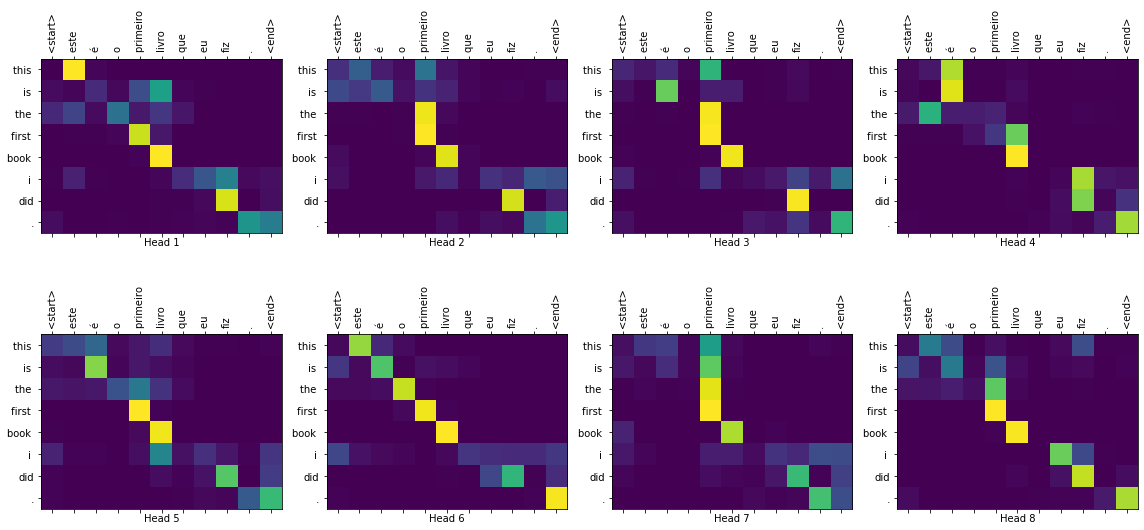

Real translation: this is the first book i've ever done.


In [37]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")